In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
import pickle 

from utils import *
from plot_functions import *

# Define Experiment Characteristics

In [4]:
# Select the prediction variable, e.g., 'Ees', 'dead_volume'
prediction_variable = 'Ees'  
variable_unit = 'mmHg/mL'

# Set XGB as the regression method
regressor = 'XGB'     

# Select input features
input_selection = 'M3'

# Enable noise addition, select noise level, e.g., 10 %, 20 %, 30 %, and select the noisy features, e.g., 'STI' or 'BP'
noise_mode = False
noise_level = 10
noisy_features = 'STI'

# Enable figure saving
save_figure_boolean = False 

experiment_type = 'insilico_{}'.format(input_selection)    # Set the type of data being used in the analysis

# Load & Prepare Data for Analysis

In [5]:
dataset = pd.read_csv('insilico_elastance_data.csv')
dataset = select_columns_based_on_input(dataset, input_selection, prediction_variable)       

dataset_scaled = scale_data(dataset)
noisy_dataset = add_random_noise(dataset_scaled, noise_level, noisy_features, input_selection,noise_mode)

print(dataset.shape)
dataset.head()

(4645, 11)


,brSBP,brDBP,heart_rate,PEP,ET,ted,tad,tes,stroke_volume,ejection_fraction,dead_volume
0,114.71,63.287,73.521,0.023826,0.312192,0.013282,0.037108,0.34930,98.457,0.59192,43.768
1,115.09,51.577,79.111,0.042831,0.240497,0.011112,0.053943,0.29444,36.284,0.40888,19.863
2,137.43,103.210,76.914,0.015603,0.359996,0.015231,0.030834,0.39083,82.801,0.66497,14.232
3,144.37,110.300,81.735,0.078059,0.278301,0.013260,0.091319,0.36962,76.025,0.44330,15.450
4,158.57,71.202,68.280,0.021716,0.292724,0.012160,0.033876,0.32660,105.740,0.62732,31.947


# Regression Analysis

The train set size is: (3251, 10)
The test set size is: (1394, 10)
Mean Absolute Error: 3.65 mmHg/mL
Mean Squared Error: 25.08 mmHg/mL
Root Mean Squared Error: 5.01 mmHg/mL
Normalized Root Mean Squared Error: 9.14 %

Correlation: 0.93
Slope: 0.86
Intercept: 3.35 mmHg/mL
r_value: 0.93
p_value: 0.0
Distribution of the reference data: 22.9 ± 14.1 mmHg/mL
Distribution of the predicted data: 23.1 ± 13.0 mmHg/mL


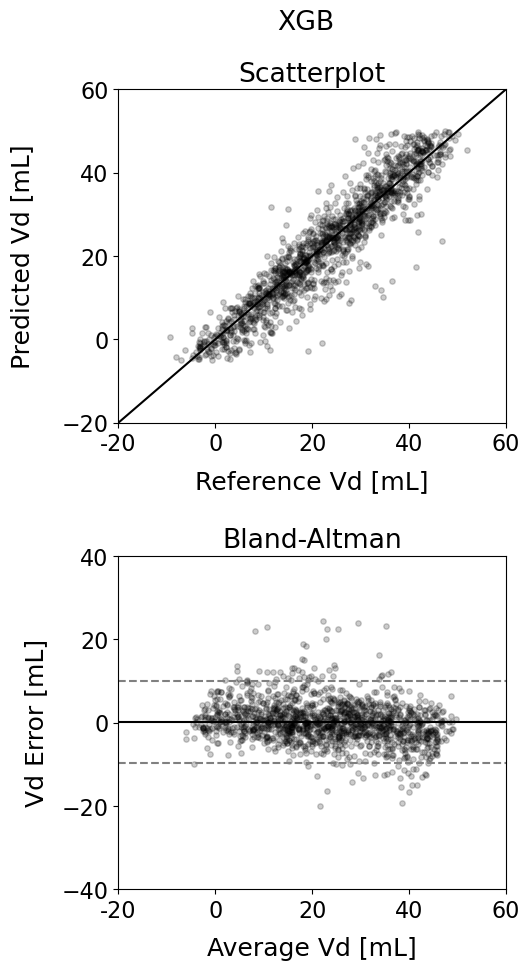

Bias: 0.16 mL
Upper LoA: 9.97 mL
Lower LoA: -9.65 mL


In [6]:
X, y = split_features_target(noisy_dataset)

# Load saved train and test indices
# train_indices, test_indices = load_train_test_indices()

indices = np.arange(len(X))
X_train, X_test, y_train, y_test,train_indices, test_indices = train_test_split(X, y, indices,test_size=0.3, random_state=42)
X_train = X[train_indices]; y_train = y[train_indices]
X_test = X[test_indices]; y_test = y[test_indices]

print('The train set size is:', X_train.shape)
print('The test set size is:', X_test.shape)

# model, y_pred, best_parameters = hyperparameter_tuning(X_train, X_test, y_train, y_test,regressor) 
model, y_pred = elastance_xgb_regressor(X_train,X_test,y_train,y_test,prediction_variable, input_selection)

rescaled_y_test = rescale_values(y_test, prediction_variable, dataset)
rescaled_y_pred = rescale_values(y_pred, prediction_variable, dataset)

print_results(rescaled_y_test, rescaled_y_pred, variable_unit)    
plot_data(rescaled_y_test, rescaled_y_pred, experiment_type,prediction_variable,regressor,save_figure_boolean)

# Calculate Learning Curves

In [ ]:
# Define the XGBoost model using optimized hyperparameters
xgb_model = set_xgboost_params(prediction_variable, input_selection)

# Define the cross-validation strategy
cv = 5

# Define the train sizes for learning curve
train_sizes = np.linspace(0.01, 1.0, 50)

# Define the scoring metric (e.g., 'neg_mean_squared_error')
scoring = 'neg_mean_squared_error'

# Plot the learning curve
plot_learning_curve(xgb_model, "Learning Curve", X, y, cv=cv, train_sizes=train_sizes, scoring=scoring)

# Show the plot
plt.show()